In [38]:
!pip install pyspark

In [39]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Energy_Consumption_Project').getOrCreate()

df1 = spark.read.csv('/content/drive/MyDrive/DATASETS/CSE3120-BDF_Project/household_power_consumption.txt', sep =';',inferSchema=True, header=True)

In [40]:
#Checking NULL Values

from pyspark.sql.functions import col,sum,isnan,avg
df1.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns)).show()

+----+----+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|Date|Time|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+----+----+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|   0|   0|                  0|                    0|      0|               0|             0|             0|         25979|
+----+----+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+



In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean
from pyspark.sql.functions import when


column_name = "Sub_metering_3"

# Calculate the mean value for the specific column
mean_value = df1.select(mean(col(column_name))).collect()[0][0]

# Fill null values in the specific column with the mean value
df1 = df1.withColumn(column_name, when(col(column_name).isNull(), mean_value).otherwise(col(column_name)))

# Show the updated DataFrame
df1.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df1.columns)).show()

+----+----+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|Date|Time|Global_active_power|Global_reactive_power|Voltage|Global_intensity|Sub_metering_1|Sub_metering_2|Sub_metering_3|
+----+----+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+
|   0|   0|                  0|                    0|      0|               0|             0|             0|             0|
+----+----+-------------------+---------------------+-------+----------------+--------------+--------------+--------------+



In [42]:
# Display the average values

avg_values = df1.agg(*(avg(col(c)).alias(c) for c in df1.columns))
avg_values.show()

+----+--------------------+-------------------+---------------------+-----------------+-----------------+------------------+------------------+-----------------+
|Date|                Time|Global_active_power|Global_reactive_power|          Voltage| Global_intensity|    Sub_metering_1|    Sub_metering_2|   Sub_metering_3|
+----+--------------------+-------------------+---------------------+-----------------+-----------------+------------------+------------------+-----------------+
|null|1.6897679727448092E9| 1.0916150365007122|  0.12371447630388838|240.8398579745544|4.627759310588417|1.1219233096502186|1.2985199679887571|6.458447357117936|
+----+--------------------+-------------------+---------------------+-----------------+-----------------+------------------+------------------+-----------------+



In [43]:
df1.describe().show()

+-------+--------+-------------------+---------------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|    Date|Global_active_power|Global_reactive_power|           Voltage| Global_intensity|    Sub_metering_1|    Sub_metering_2|   Sub_metering_3|
+-------+--------+-------------------+---------------------+------------------+-----------------+------------------+------------------+-----------------+
|  count| 2075259|            2075259|              2075259|           2075259|          2075259|           2075259|           2075259|          2075259|
|   mean|    null| 1.0916150365007122|  0.12371447630388838| 240.8398579745544|4.627759310588417|1.1219233096502186|1.2985199679887571|6.458447357117936|
| stddev|    null| 1.0572941610939701|   0.1127219795507155|3.2399866790098937|4.444396259786192|  6.15303108970134| 5.822026473177461|8.384177573993572|
|    min|1/1/2007|              0.076|                0.000|           223.2

In [44]:
df = df1.toPandas()
df.head()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,2023-07-19 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,2023-07-19 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,2023-07-19 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,2023-07-19 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,2023-07-19 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM ,Dropout ,Dense
from sklearn.metrics import mean_squared_error,r2_score


In [46]:
df = pd.read_csv('/content/drive/MyDrive/DATASETS/CSE3120-BDF_Project/household_power_consumption.txt', sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')


df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [47]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [48]:
df = df.fillna(df.mean())

In [49]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

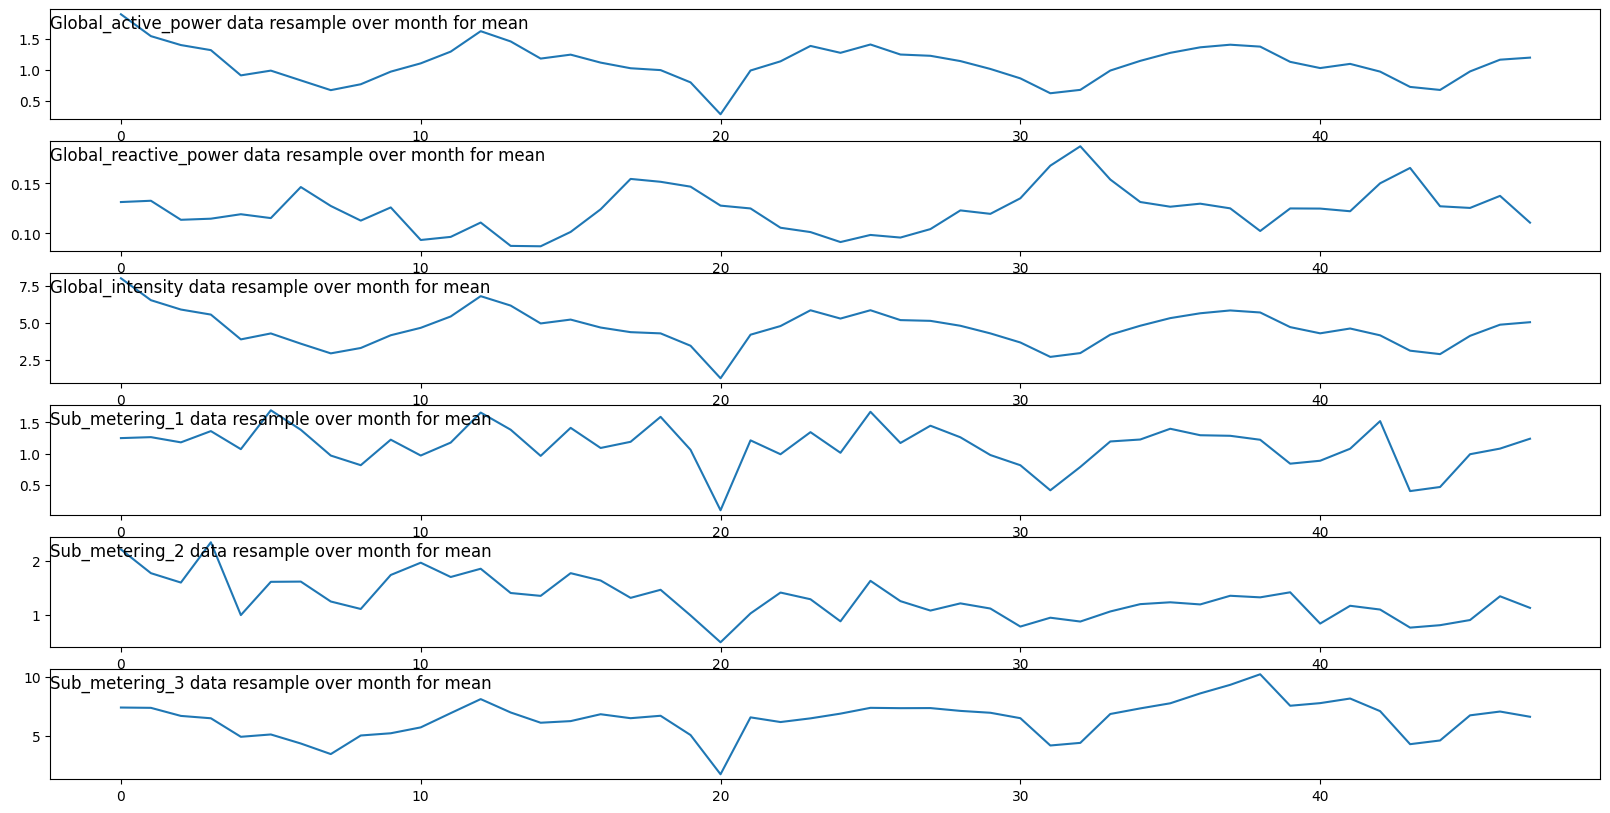

In [50]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('M').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.show()

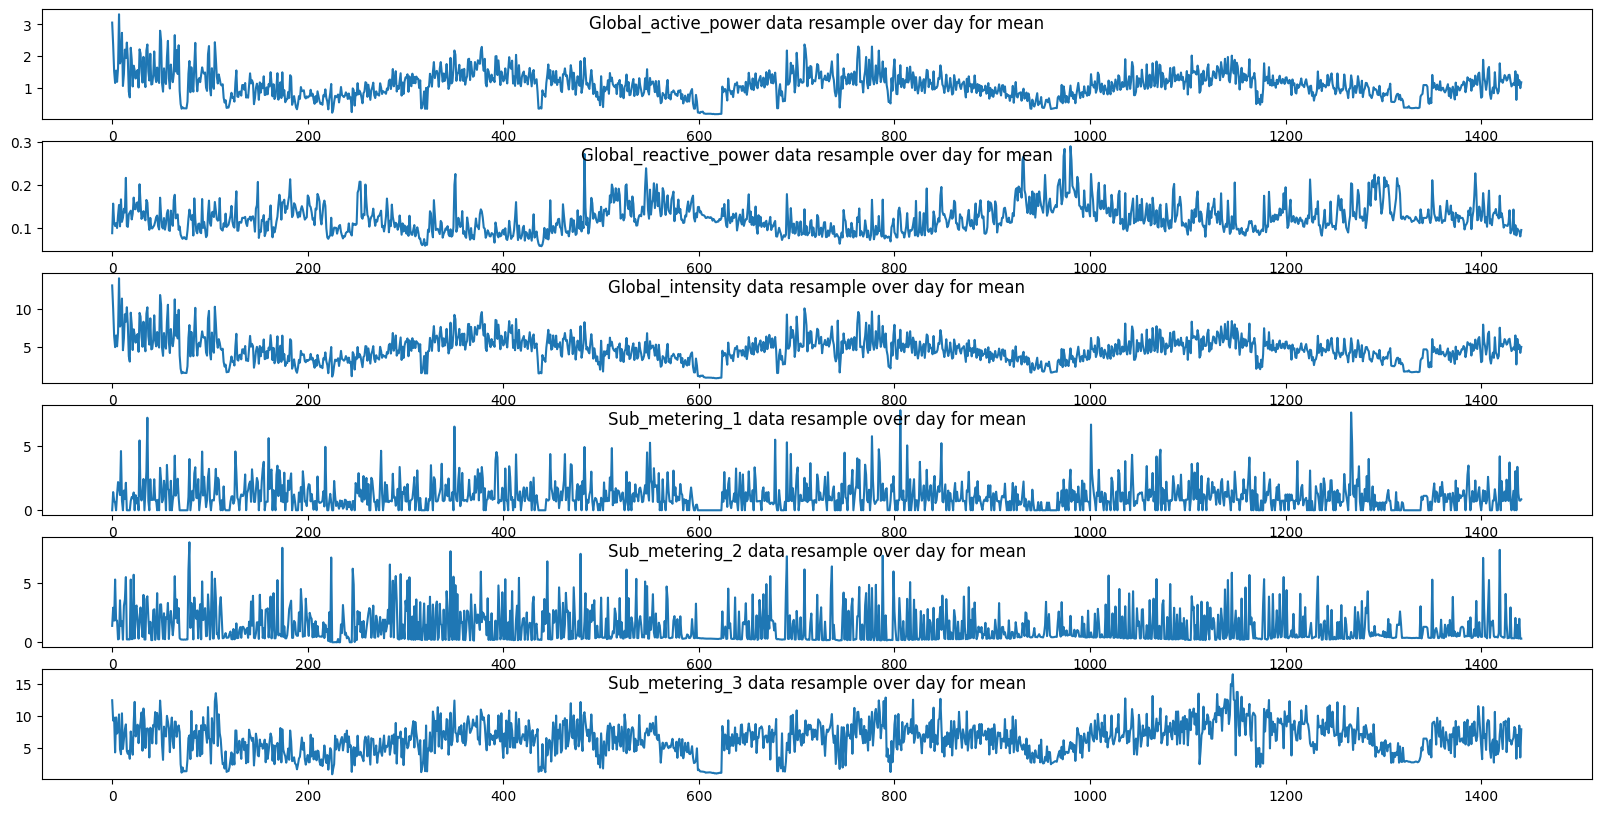

In [51]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('D').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.show()

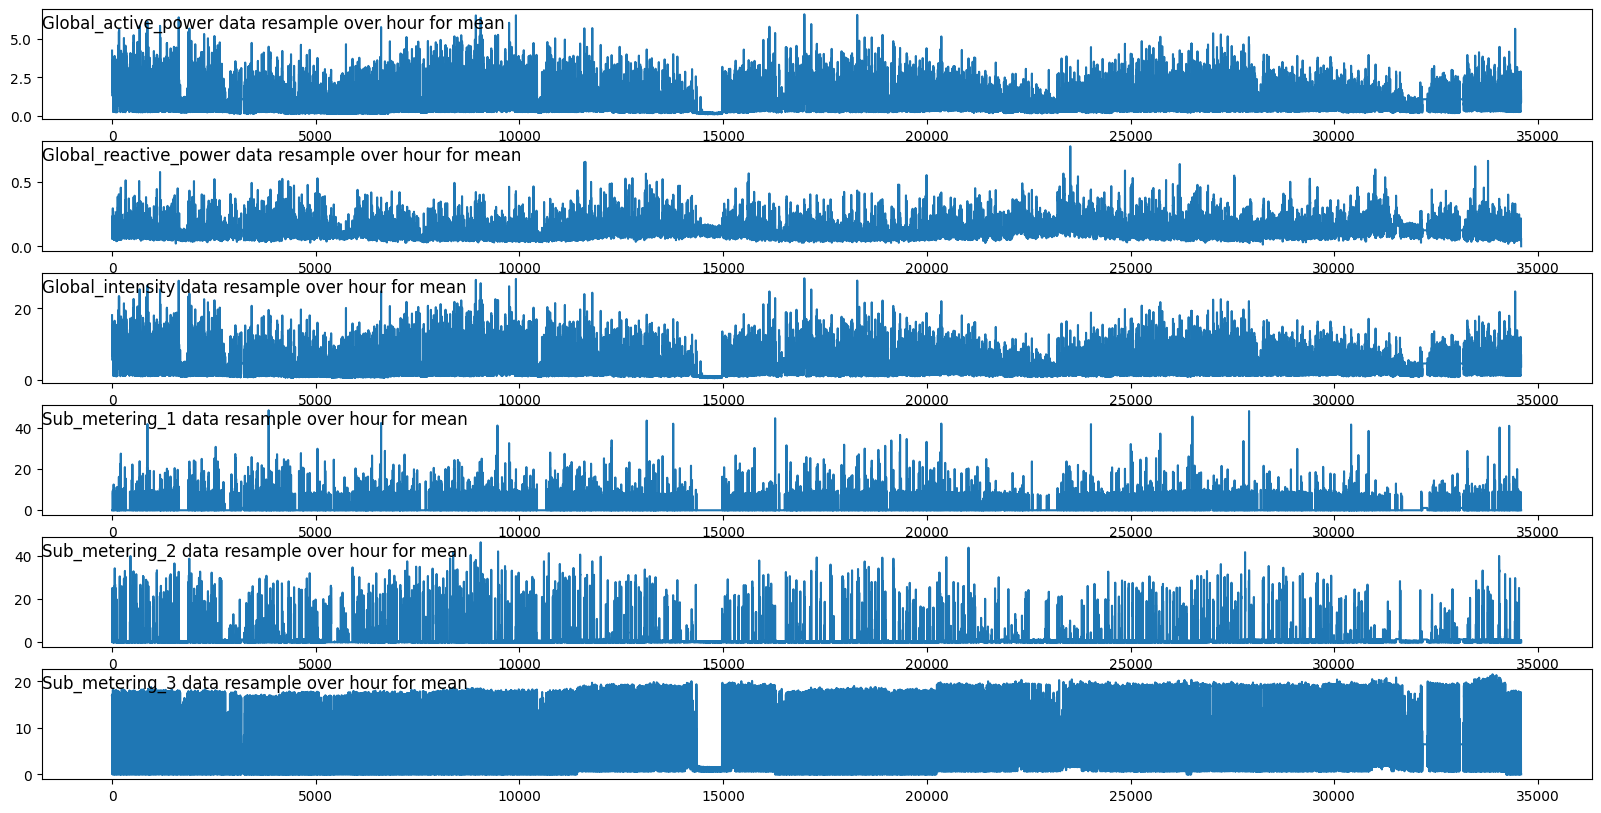

In [52]:
i = 1
cols=[0, 1, 3, 4, 5, 6]
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    plt.plot(df.resample('H').mean().values[:, col])
    plt.title(df.columns[col] + ' data resample over hour for mean', y=0.75, loc='left')
    i += 1
plt.show()

In [53]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(-i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [54]:
df = df[['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

df_resample = df.resample('h').mean()
df_resample.shape

(34589, 7)

In [55]:
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 4000 #train_size change anytime
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [56]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model.fit(train_x, train_y, epochs=50, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)


Epoch 1/50
58/58 - 8s - loss: 0.0327 - val_loss: 0.0113 - 8s/epoch - 133ms/step
Epoch 2/50
58/58 - 2s - loss: 0.0156 - val_loss: 0.0101 - 2s/epoch - 26ms/step
Epoch 3/50
58/58 - 1s - loss: 0.0144 - val_loss: 0.0100 - 1s/epoch - 17ms/step
Epoch 4/50
58/58 - 2s - loss: 0.0136 - val_loss: 0.0099 - 2s/epoch - 26ms/step
Epoch 5/50
58/58 - 2s - loss: 0.0131 - val_loss: 0.0098 - 2s/epoch - 26ms/step
Epoch 6/50
58/58 - 2s - loss: 0.0127 - val_loss: 0.0096 - 2s/epoch - 29ms/step
Epoch 7/50
58/58 - 2s - loss: 0.0125 - val_loss: 0.0096 - 2s/epoch - 26ms/step
Epoch 8/50
58/58 - 2s - loss: 0.0122 - val_loss: 0.0095 - 2s/epoch - 29ms/step
Epoch 9/50
58/58 - 2s - loss: 0.0121 - val_loss: 0.0094 - 2s/epoch - 26ms/step
Epoch 10/50
58/58 - 1s - loss: 0.0120 - val_loss: 0.0093 - 1s/epoch - 20ms/step
Epoch 11/50
58/58 - 2s - loss: 0.0118 - val_loss: 0.0093 - 2s/epoch - 26ms/step
Epoch 12/50
58/58 - 2s - loss: 0.0118 - val_loss: 0.0092 - 2s/epoch - 26ms/step
Epoch 13/50
58/58 - 2s - loss: 0.0118 - val_loss

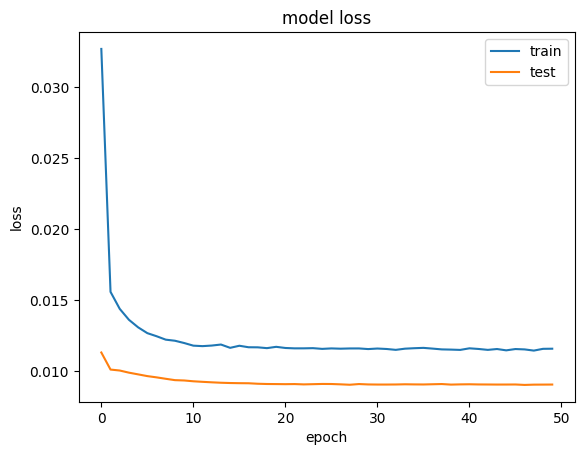

In [57]:
# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [58]:
size = df_resample.shape[1]

# Prediction test
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


956/956 [==============================] - 3s 3ms/step
Test RMSE: 0.612


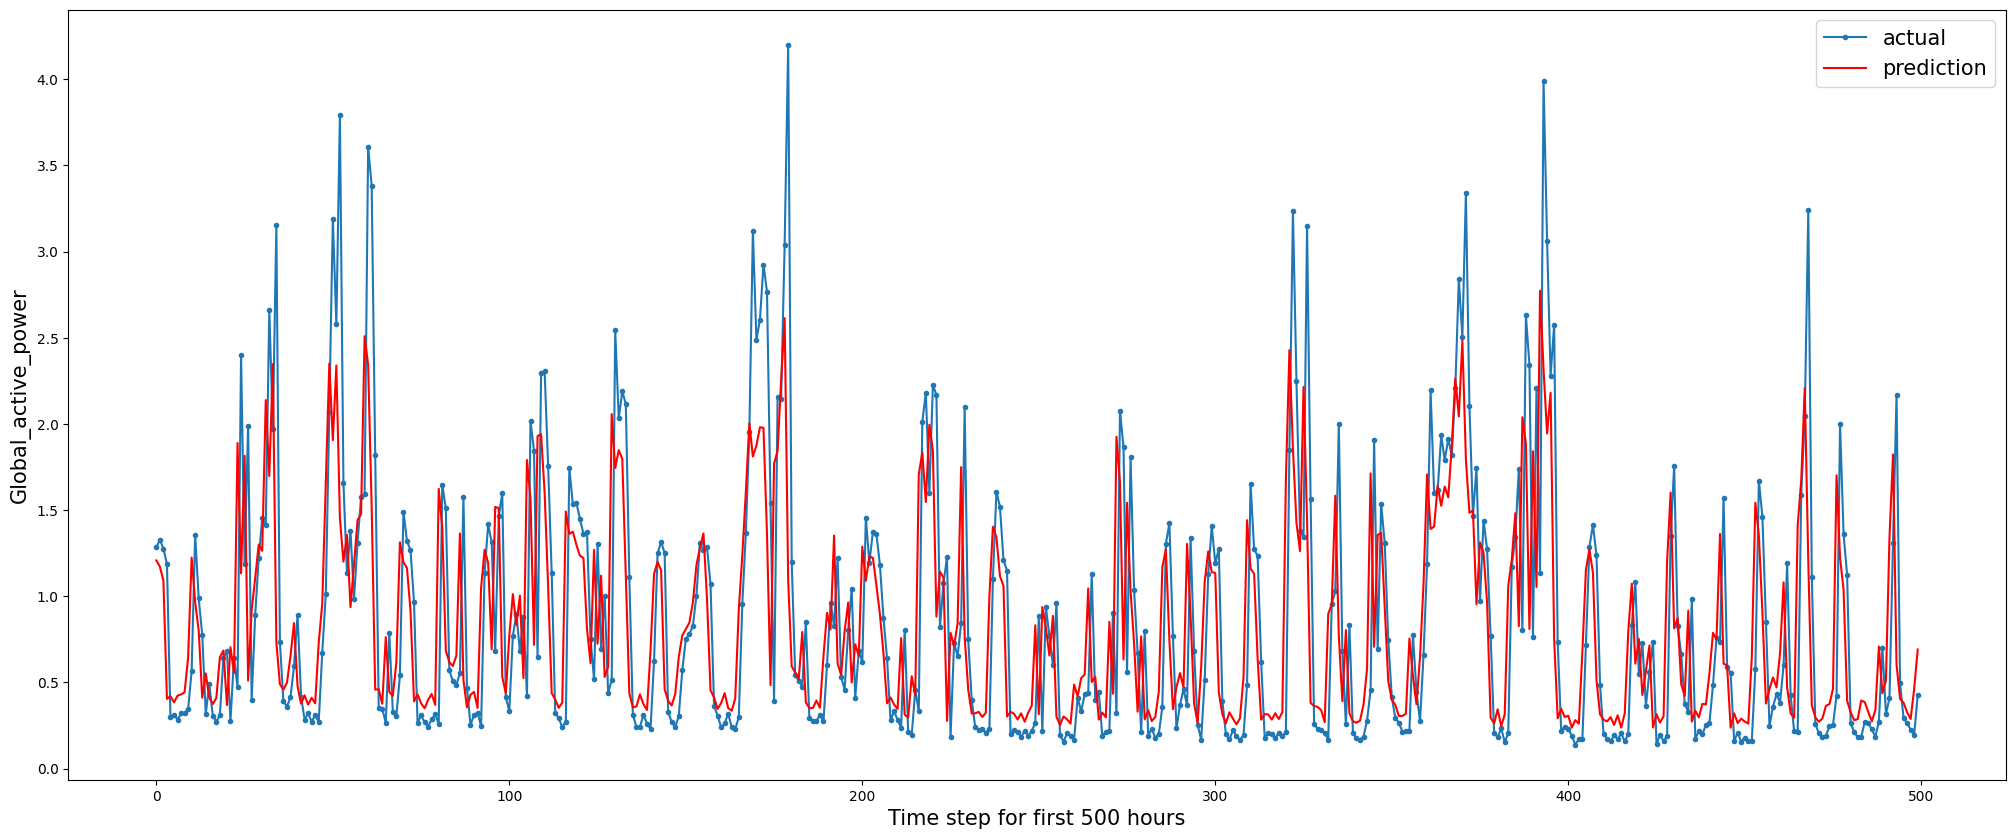

In [59]:
aa=[x for x in range(500)]
plt.figure(figsize=(25,10))
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 500 hours', size=15)
plt.legend(fontsize=15)
plt.show()